# Water Quality of Credit River

The goal of this notebook is to collect the water quality data of Credit River and analyze it. The source data is available on https://data.ontario.ca/dataset/provincial-stream-water-quality-monitoring-network.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

First is necessary to import the CSV collected from the website. We are going to use the data from 2010 to 2018. It's also necessary to normalize the Date for future analyze.

In [2]:
df = pd.read_csv('Ontario_Data/Water_Quality/water_quality_2010-2018.csv', sep=',')
df['DATE_YYYYMMDD'] = pd.to_datetime(df['DATE_YYYYMMDD'].astype(str), format='%Y%m%d').dt.date
df.head(5)

C:\Users\IEP User 4\AppData\Local\Temp\ipykernel_5480\772916038.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Ontario_Data/Water_Quality/water_quality_2010-2018.csv', sep=',')


,STATION,PARM,PARM_DESCRIPTION,YEAR,DATE_YYYYMMDD,TIME_HH:MM,FIELD_NO,REMARK_CODE,RESULT,VALUQUALIFI,UNITS,ANALMETHOD
0,18003302302,RSP,"RESIDUE,PARTICULATE",2010,2010-09-23,13:44,0,< T,1.40,< T,MILLIGRAM PER LITER,E3188B
1,18003302302,ALKT,"ALKALINITY, TOTAL",2010,2010-09-23,13:44,0,NaN,58.40,NaN,MILLIGRAM PER LITER,E3218A
2,18003302302,COND25,"CONDUCTIVITY, 25C",2010,2010-09-23,13:44,0,NaN,135.00,NaN,MICRO SIEMENS PER CENTIMETER,E3218A
3,18003302302,PH,PH (-LOG H+ CONCN),2010,2010-09-23,13:44,0,NaN,8.09,NaN,NO DIMENSION/SCALE,E3218A
4,18003302302,CLIDUR,"CHLORIDE, UNFIL.REAC",2010,2010-09-23,13:44,0,NaN,4.10,NaN,MILLIGRAM PER LITER,E3016A


We don't have the information about which rivers those stations refers so we also have to collect the data of the description of each river. The data is also available on the website on "Supporting Files". The CSV name is Coordinates.

https://data.ontario.ca/dataset/provincial-stream-water-quality-monitoring-network/resource/858d74bb-5aa5-4578-a5a3-49e28c5445c5

In [3]:
df_stations = pd.read_csv('Ontario_Data/Water_Quality/water_quality_stations.csv', sep=',')
credit_river_stations = df_stations[df_stations.NAME == 'Credit River']
credit_river_stations = credit_river_stations[credit_river_stations.LAST_YEAR > 2010]
credit_river_stations
credit_river_stations[['DESCRIPTION', 'LATITUDE', 'LONGITUDE']].to_csv('Ontario_Data/Water_Quality/water_quality_stations_credit_river.csv', sep=',', index=False)

In order to facilitate the future analyzes, we are going to select only the important columns and rows.

In [4]:
df_credit = df[df.STATION.isin(credit_river_stations.STATION)].sort_values(by='STATION')[['STATION', 'DATE_YYYYMMDD', 'TIME_HH:MM', 'PARM_DESCRIPTION', 'UNITS','RESULT', 'PARM']]
df_credit.head(5)

,STATION,DATE_YYYYMMDD,TIME_HH:MM,PARM_DESCRIPTION,UNITS,RESULT,PARM
309411,6007600302,2013-05-29,12:15,"ZIRCONIUM, UNFILTERED TOTAL",MICROGRAM PER LITER,0.2610,ZRUT
487735,6007600302,2014-10-29,12:40,"SODIUM, UNFILTERED TOTAL",MILLIGRAM PER LITER,49.6000,NAUT
487736,6007600302,2014-10-29,12:40,"NICKEL, UNFILTERED TOTAL",MICROGRAM PER LITER,-0.0586,NIUT
487737,6007600302,2014-10-29,12:40,"AMMONIUM, TOTAL UNFIL.REAC",MILLIGRAM PER LITER,0.0240,NNHTUR
92717,6007600302,2011-01-05,9:40,STREAM CONDITION,NO DIMENSION/SCALE,8.0000,FWSTRC


Dropdown(description='PARAMETER:', index=2, options=('PICK A PARAMETER', 'ZIRCONIUM,  UNFILTERED TOTAL', 'SODI…

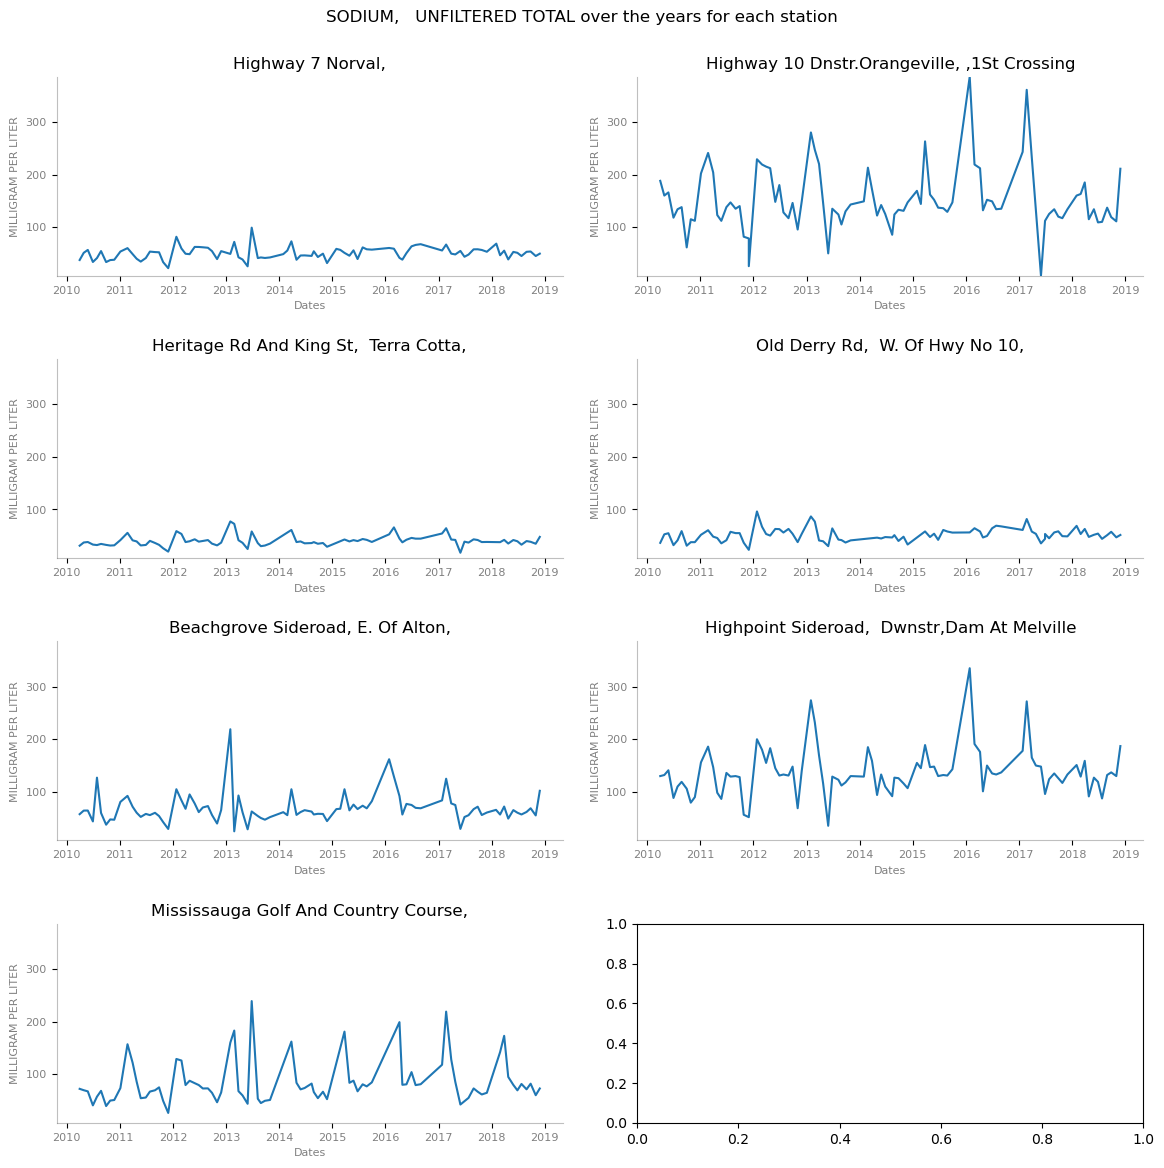

In [5]:
variables_par = df_credit['PARM_DESCRIPTION'].unique()
variables_par = np.insert(variables_par, 0, 'PICK A PARAMETER')

# Create a dropdown widget
dropdown = widgets.Dropdown(
    options=variables_par,
    value=variables_par[0],
    description='PARAMETER:',
    disabled=False,
)

# Display the widget
display(dropdown)

selected_par = 'PICK A PARAMETER'
def on_value_change(change):
    global selected_par
    clear_output(wait=True)
    display(dropdown)
    selected_par = change['new']

    # Select max and min limits for the parameter
    max = df_credit[(df_credit['PARM_DESCRIPTION'] == selected_par) & (df_credit.RESULT.notna())]['RESULT'].max()
    min = df_credit[(df_credit['PARM_DESCRIPTION'] == selected_par) & (df_credit.RESULT.notna())]['RESULT'].min()

    # Display the graph of each station for the specified parameter
    count = 1
    fig, axes = plt.subplots(nrows=int((len(credit_river_stations)+1)/2), ncols=2, figsize=(12, 12))
    for i in range(int((len(credit_river_stations)+1)/2)):
        for j in range(2):
            if(count > len(credit_river_stations)):
                break
            station_num = credit_river_stations.STATION.values[count-1]
            station_name = credit_river_stations.DESCRIPTION.values[count-1]
            station = df_credit[(df_credit.STATION == station_num) & (df_credit['PARM_DESCRIPTION'] == selected_par)].sort_values(by='DATE_YYYYMMDD')
            
            # ----- Graph design -----
            alpha = 0.5
            # Xticks and Yticks
            for label in axes[i,j].get_xticklabels() + axes[i,j].get_yticklabels():
                label.set_alpha(alpha)
                label.set_size(8)
            # Spines
            for spine in axes[i,j].spines.values():
                spine.set_color('gray')
                spine.set_alpha(alpha)
            axes[i,j].spines['top'].set_alpha(0)
            axes[i,j].spines['right'].set_alpha(0)
            # Labels
            axes[i,j].set_xlabel('', alpha=alpha, fontsize=8)
            axes[i,j].set_ylabel('', alpha=alpha, fontsize=8)
            
            axes[i,j].set_xlabel('Dates')
            axes[i,j].set_ylabel(station['UNITS'].unique()[0])
            axes[i,j].set_title(f'{station_name}')
            axes[i,j].plot(station['DATE_YYYYMMDD'], station['RESULT'])
            axes[i,j].set_ylim(min, max)
            count += 1
    fig.suptitle(f'{selected_par} over the years for each station')
    plt.tight_layout(pad=2.0)
    plt.show()

# Attach the function to the dropdown
dropdown.observe(on_value_change, names='value')

Now we have to separate the important parameters for our model. We are looking for the major ions, such as Cl-, NO3-, SO42-, NH4+, Na+, K+, Ca2+, Mg2+.

In [6]:
parameters = ['CHLORIDE,         UNFIL.REAC', 'NITRATES TOTAL,   UNFIL.REAC', 'AMMONIUM, TOTAL   UNFIL.REAC', 'SODIUM,   UNFILTERED TOTAL', 'POTASSIUM,UNFILTERED TOTAL', 'CALCIUM, UNFILTERED TOTAL', 'MAGNESIUM,UNFILTERED TOTAL']
df_credit_sep = df_credit[df.PARM_DESCRIPTION.isin(parameters)].sort_values(by=['DATE_YYYYMMDD','TIME_HH:MM'])

C:\Users\IEP User 4\AppData\Local\Temp\ipykernel_5480\559758405.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_credit_sep = df_credit[df.PARM_DESCRIPTION.isin(parameters)].sort_values(by=['DATE_YYYYMMDD','TIME_HH:MM'])


In [7]:
df_credit_sep.to_csv('water_quality_separated_data_2010-2018.csv', sep=',', index=False)

## Extra analysis

It happened two times during the eight years of data collecting of one station doing the same analysis twice a day. So in the data integration it will be necessary to deal with this problem.

In [25]:
dup = df_credit_sep.sort_values(by=['STATION', 'DATE_YYYYMMDD', 'PARM_DESCRIPTION'])
dup[dup.duplicated(subset=['STATION', 'DATE_YYYYMMDD', 'PARM_DESCRIPTION'], keep=False)]

,STATION,DATE_YYYYMMDD,TIME_HH:MM,PARM_DESCRIPTION,UNITS,RESULT,PARM
191410,6007600602,2011-11-30,11:45,"AMMONIUM, TOTAL UNFIL.REAC",MILLIGRAM PER LITER,0.038,NNHTUR
191840,6007600602,2011-11-30,8:15,"AMMONIUM, TOTAL UNFIL.REAC",MILLIGRAM PER LITER,0.107,NNHTUR
191423,6007600602,2011-11-30,11:45,"CALCIUM, UNFILTERED TOTAL",MILLIGRAM PER LITER,58.400,CAUT
191853,6007600602,2011-11-30,8:15,"CALCIUM, UNFILTERED TOTAL",MILLIGRAM PER LITER,42.300,CAUT
191409,6007600602,2011-11-30,11:45,"CHLORIDE, UNFIL.REAC",MILLIGRAM PER LITER,122.000,CLIDUR
191839,6007600602,2011-11-30,8:15,"CHLORIDE, UNFIL.REAC",MILLIGRAM PER LITER,43.600,CLIDUR
191430,6007600602,2011-11-30,11:45,"MAGNESIUM,UNFILTERED TOTAL",MILLIGRAM PER LITER,11.400,MGUT
191860,6007600602,2011-11-30,8:15,"MAGNESIUM,UNFILTERED TOTAL",MILLIGRAM PER LITER,8.990,MGUT
191411,6007600602,2011-11-30,11:45,"NITRATES TOTAL, UNFIL.REAC",MILLIGRAM PER LITER,0.801,NNOTUR
191841,6007600602,2011-11-30,8:15,"NITRATES TOTAL, UNFIL.REAC",MILLIGRAM PER LITER,3.040,NNOTUR
